In [554]:
import pandas as pd  
import os, sys, re 
import spacy


import nltk, gensim
from bs4 import BeautifulSoup
from nltk.tokenize import ToktokTokenizer
from nltk.stem import wordnet
from nltk.corpus import stopwords
from string import punctuation
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.utils import shuffle
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import homogeneity_score


In [555]:
def list_directories(path):
    """list files and directories in a given path"""
    arr = os.listdir(path)
    return arr

In [556]:
files = list_directories('data2')
len(files)


109

In [524]:
files_names = []
for f in files:
    files_names.append(f.split('_')[:-2][0])
len(files_names)  ## labels 

files_names[0]

'Advertising & Public Relations'

In [525]:
files_headlines = []
for f in range(0,len(files),1): 
    df=pd.read_csv('data2/'+files[f])
    for headline in list(df['job-title']):

        files_headlines.append([ headline, files_names[f] ] )
                             
print(len(files_headlines))

df = pd.DataFrame(files_headlines, columns = ['text', 'label'])
df = shuffle(df)

16878


In [526]:
df.head()

,text,label
1984,Digital Media Coordinator,English Language & Literature
8386,Telephonic Medical Assistant,Medical Assisting Services
12341,Academic Planning Specialist,General Education
9670,Online Technology Intern,Computer Programming & Data Processing
13847,"Chief of Staff, Office Engineering",Engineering


In [527]:
df.to_csv('clustering_jobs_data.csv',encoding='utf-8', index=False)

In [528]:
top_tags = []

def list_directories(path):
    """list files and directories in a given path"""
    arr = os.listdir(path)
    return arr


def clean_text(text):
    ''' Lowering text and removing undesirable marks
    '''
    
    text = text.lower()
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text) # matches all whitespace characters
    text = text.strip(' ')
    return text
    

token = ToktokTokenizer()
punct = punctuation
    
def strip_list_noempty(mylist):
    
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']
    
    
def clean_punct(text): 
    ''' Remove punctuations'''
    
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    
    for w in words:
        if w in top_tags:
            punctuation_filtered.append(w)
        else:
            w = re.sub('^[0-9]*', " ", w)
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))


stop_words = set(stopwords.words("english"))

def stopWordsRemove(text):
    ''' Removing all the english stop words from a corpus
    Parameter:
    text: corpus to remove stop words from it
    '''

    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))
    
    
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags, stop_words=stop_words):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the underired POS tags
    
    Parameters:
    
    texts (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADL, VERB, ADV
    '''
    lemma = wordnet.WordNetLemmatizer()       
    doc = nlp(texts) 
    texts_out = []
    
    for token in doc:
        
        if str(token) in top_tags:
            texts_out.append(str(token))
            
        elif token.pos_ in allowed_postags:
            
            if token.lemma_ not in ['-PRON-']:
                texts_out.append(token.lemma_)
                
            else:
                texts_out.append('')
     
    texts_out = ' '.join(texts_out)

    return texts_out
    
    
def strip_emoji(text):
#     print(emoji.emoji_count(text))
    new_text = re.sub(emoji.get_emoji_regexp(), r"", text)
    return new_text



def preprocess_text(df,column='job-title'):
    
    df[column] = df[column].apply(lambda x: clean_text(x))
    df[column] = df[column].apply(lambda x:  BeautifulSoup(x).get_text())
    df[column] = df[column].apply(lambda x: strip_emoji(x))

    df[column] = df[column].apply(lambda x: clean_punct(x)) 
#     df[column] = df[column].apply(lambda x: stopWordsRemove(x)) 
#     df[column] = df[column].apply(lambda x: lemmatization(x, ['NOUN', 'ADV']))

    return df

def generate_tags(df,column='description'):
    
    countVec =CountVectorizer(ngram_range=(1,5))
    cv = countVec.fit_transform(df[column].str.lower())
    cv_feature_names = countVec.get_feature_names()
    feature_count = cv.toarray().sum(axis = 0)
    feature_count = sorted(dict(zip(cv_feature_names, feature_count)).items(), key=lambda item: item[1])[::-1][:50]

    return feature_count

In [529]:
# df = preprocess_text(df,column='text')


In [530]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.text.values)
features = vec.transform(df.text.values)

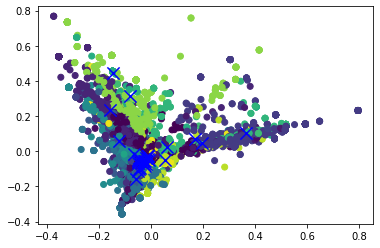

0.2057268354171787


In [543]:
random_state = 0 
cls = MiniBatchKMeans(n_clusters=30,random_state=random_state)
cls.fit(features)

# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.show()
print(homogeneity_score(df.label, cls.predict(features)))

In [544]:
len(list(cls.labels_))


16878

In [545]:

pred_labels = list(list(cls.labels_))
df_labels = list(df['text'])

collection = list(zip(df_labels,pred_labels))
len(collection)

16878

In [546]:
groups =pd.DataFrame(collection,columns=['job-title','cluster'])
c = 0
for i in range(0,30,1):    
    temp = groups[groups['cluster'] == i]
    temp.to_csv(f'clusters/cluster{i}.csv',encoding='utf-8', index=False)
    print(f'cluster {i} has {len(temp)} headline')
    c+=len(temp)

print(c)

cluster 0 has 4690 headline
cluster 1 has 388 headline
cluster 2 has 443 headline
cluster 3 has 739 headline
cluster 4 has 746 headline
cluster 5 has 1287 headline
cluster 6 has 928 headline
cluster 7 has 92 headline
cluster 8 has 395 headline
cluster 9 has 594 headline
cluster 10 has 2 headline
cluster 11 has 1311 headline
cluster 12 has 99 headline
cluster 13 has 220 headline
cluster 14 has 690 headline
cluster 15 has 92 headline
cluster 16 has 209 headline
cluster 17 has 455 headline
cluster 18 has 123 headline
cluster 19 has 517 headline
cluster 20 has 101 headline
cluster 21 has 34 headline
cluster 22 has 60 headline
cluster 23 has 194 headline
cluster 24 has 741 headline
cluster 25 has 106 headline
cluster 26 has 393 headline
cluster 27 has 188 headline
cluster 28 has 859 headline
cluster 29 has 182 headline
16878


In [552]:
temp = groups[groups['cluster'] == 22]
temp

,job-title,cluster
306,Math Teacher/Mentor,22
483,Math and Science Teacher Mentor,22
1138,Math Teacher/Mentor,22
1246,Math and Science Teacher Mentor,22
1382,Math Teacher Mentor,22
1621,Math and Science Teacher,22
2504,Math Teacher Mentor,22
2567,Math Teacher Mentor,22
2673,Math Teacher Mentor,22
2898,Math and Science Teacher Mentor,22


In [553]:
temp = groups[groups['cluster'] == 7]
temp

,job-title,cluster
30,Creative Director,7
76,Creative Coordinator,7
131,Merchandising/Creative Review Coordinator,7
405,Creative Project Manager,7
604,Creative Director,7
...,...,...
15972,"Manager, Marketing and Creative Strategy",7
16155,Associate Creative Director (Copy),7
16382,"VP, Creative Advertising, Searchlight Pictures",7
16703,Creative Director,7
